In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession, Row, functions
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, ArrayType, FloatType
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Spark Session, Pipeline, Functions, and Metrics
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import rand
from pyspark.mllib.evaluation import MulticlassMetrics

# Keras / Deep Learning
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from keras.optimizers import Adam

# Elephas for Deep Learning on Spark
from elephas.ml_model import ElephasEstimator

In [5]:
spark = SparkSession.builder \
   .master("local") \
   .appName("test") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()

In [2]:
conf = SparkConf().setAppName('Spark DL Tabular Pipeline').setMaster('local[6]')
sc = SparkContext(conf=conf)
sql_context = SQLContext(sc)

In [141]:
df = sql_context.read.csv('data.csv')

In [2]:
sc.stop()

In [153]:
df = df.withColumn("_c0",functions.expr("substring(_c0, 2, length(_c0)-1)"))
df = df.withColumn("_c3",functions.expr("substring(_c3, 1, length(_c3)-1)"))

In [154]:
df = df.withColumnRenamed("_c0", "form_id")\
        .withColumnRenamed("_c1", "views")\
        .withColumnRenamed("_c2", "submissions")\
        .withColumnRenamed("_c3", "features")

In [155]:
df.take(2)

[Row(form_id='1113027', views='33', submissions='27', features='0.0-0.0-0.0-0.0-0.0-0.0-1.0-0.0-1.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-2.0-0.0-2.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-2.0-1.0-2.0'),
 Row(form_id='1115313', views='147', submissions='111', features='0.0-2.0-0.0-0.0-0.0-0.0-0.0-0.0-1.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-3.0-0.0-3.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0-0.0')]

In [156]:
df2 = df.select('form_id','views','submissions', functions.split('features', '-').alias('features'))

df_sizes = df2.select(functions.size('features').alias('features'))
df_max = df_sizes.agg(functions.max('features'))
nb_columns = df_max.collect()[0][0]

data = df2.select('form_id','views','submissions', *[df2['features'][i] for i in range(nb_columns)])

In [157]:
del df2,df, df_max, df_sizes

In [158]:
data = data.select(*(functions.col(column).cast("float").alias(column) for column in data.columns))
data = data.withColumn('form_id', functions.col('form_id').cast('int'))
data = data.withColumn('views', functions.col('views').cast('int'))
data = data.withColumn('submissions', functions.col('submissions').cast('int'))

In [159]:
data.limit(5).toPandas()

,form_id,views,submissions,features[0],features[1],features[2],features[3],features[4],features[5],features[6],...,features[37],features[38],features[39],features[40],features[41],features[42],features[43],features[44],features[45],features[46]
0,1113027,33,27,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0
1,1115313,147,111,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1115907,528,136,0.0,1.0,0.0,0.0,1.0,0.0,6.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,30.0
3,1116299,55,21,0.0,2.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0
4,1120373,62,54,0.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,11.0,7.0,21.0


In [160]:
data.count()

1031284

In [161]:
data = data.withColumn("submission_ratio",functions.col("submissions")/functions.col("views"))

# Exploratory Data Analysis

Data we have is about a Million rows,  I will sample 10% of rows for getting faster insights with the machine capacity I have.

In [162]:
data_sample = data.sample(False, 0.1, seed = 20)
_data_p = data_sample.toPandas()

In [163]:
_data_p.shape

(103416, 51)

In [282]:
_data_p.head()

,form_id,views,submissions,features[0],features[1],features[2],features[3],features[4],features[5],features[6],...,features[38],features[39],features[40],features[41],features[42],features[43],features[44],features[45],features[46],submission_ratio
0,1135259,66406,44258,1.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,7.0,0.666476
1,1145334,536,104,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.194030
2,1161283,17,12,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.705882
3,1213407,178,56,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.314607
4,1213844,88,13,0.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.147727


Lets keep aside 'views' and 'submissions' columns I already have submission_ration column which is column of interest for us.

In [293]:
_data_p.drop(axis=1,columns=['views','submissions'], inplace=True)

### Target Variable

We need to predict submission_ratio for a form. Let's take a look at 'subission_ratio' distribution.

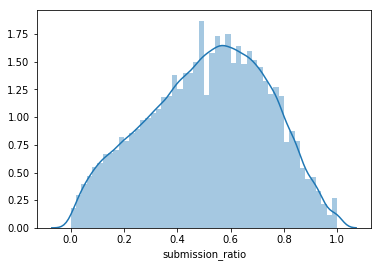

In [296]:
sns.distplot(_data_p['submission_ratio']);

Looks like a Gaussian Distribution. It seems to be fairly symmetrical.

In [299]:
#skewness and kurtosis
print("Skewness: %f" % _data_p['submission_ratio'].skew())
print("Kurtosis: %f" % _data_p['submission_ratio'].kurt())

Skewness: -0.179234
Kurtosis: -0.721690


Skewness and Kurtosis are fairly low. It doesn't seem to have any outliers.

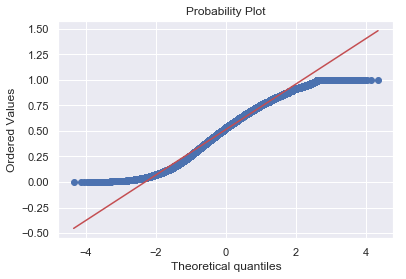

In [382]:
from scipy import stats
res = stats.probplot(_data_p['submission_ratio'], plot=plt)

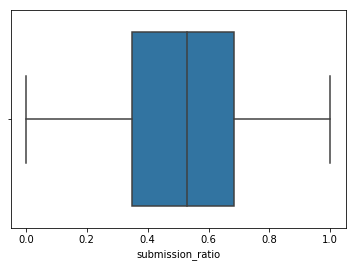

In [300]:
sns.boxplot(_data_p['submission_ratio'])

One of the best boxplots I had come across. Good distribution and no outliers.

## Handling Missing Values

In [294]:
_data_p.isna().sum()

form_id             0
features[0]         0
features[1]         0
features[2]         0
features[3]         0
features[4]         0
features[5]         0
features[6]         0
features[7]         0
features[8]         0
features[9]         0
features[10]        0
features[11]        0
features[12]        0
features[13]        0
features[14]        0
features[15]        0
features[16]        0
features[17]        0
features[18]        0
features[19]        0
features[20]        0
features[21]        0
features[22]        0
features[23]        0
features[24]        0
features[25]        0
features[26]        0
features[27]        0
features[28]        0
features[29]        0
features[30]        0
features[31]        0
features[32]        0
features[33]        0
features[34]        0
features[35]        0
features[36]        0
features[37]        0
features[38]        0
features[39]        0
features[40]        0
features[41]        0
features[42]        0
features[43]        0
features[4

There seems to be no missing values in dataset. I'm assuming same holds good for the population. If there are missing values we can work on various imputation methods or other dropping techniques.

### Ouliers Handling

Anomalies in data can be notorious if we feed to certain ML models. For example in a linear regression addition of one oulier can push the regression line completely in different direction. Anomalies can be available in data because of true outlier observation or because of errors during data ingestion or measurement error. It is important to identify anomalies and treat them right with the help of domain knowledge, statistical analysis.

For this analysis I'm doing a blanket outlier identification using Z-Score. If any observation Z-Score is greater than 3 lets consider it as outlier for simiplicity. When Deeper analysis is done we can do extreme value analysis, proximity methods, applying domain knwoledge etc to understand Outliers better.

In [302]:
def detect_outlier(data):
    
    threshold=3
    mean = np.mean(data)
    std =np.std(data)
    outliers=[]
    
    for y in data:
        z_score= (y - mean)/std 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [311]:
columns = []
outlier_count = []
unique_count = []
unique_col_values = []
for col in _data_p.columns:
    if col != 'form_id':
        outliers = detect_outlier(_data_p[col])
        count = len(outliers)
        unique = len(set(outliers))
        if count>0:
            columns.append(col)
            outlier_count.append(count)
            unique_count.append(unique)
            unique_col_values.append(len(_data_p[col].unique()))
            
outlier_count_df = pd.DataFrame({"column":columns, "outlier_count":outlier_count, \
                                 "unique_outlier_count":unique_count,"unique_val_count":unique_col_values})
outlier_count_df.head()

,column,outlier_count,unique_outlier_count,unique_val_count
0,features[1],1335,24,28
1,features[2],731,24,26
2,features[3],101,2,3
3,features[4],843,22,24
4,features[5],1053,33,37


One of the focus areas while handling outliers is if number of unique outlier values in a feature is 1 or 2 it indicates either its default value assigned or it may be a categorical variable encoded using Target Encoding or WOE etc.

In [314]:
outlier_count_df.sort_values(["unique_outlier_count"], axis=0, ascending=True)

,column,outlier_count,unique_outlier_count,unique_val_count
18,features[19],201,1,2
2,features[3],101,2,3
13,features[14],1133,6,7
6,features[7],235,7,9
8,features[9],1330,8,9
33,features[34],1068,9,10
11,features[12],2216,12,13
42,features[43],4481,13,14
29,features[30],845,13,14
30,features[31],1022,13,14


'features[19]' seems to be a binary feature holding a value of 1 or 0 with very high 0s causing 1s to show as outliers.

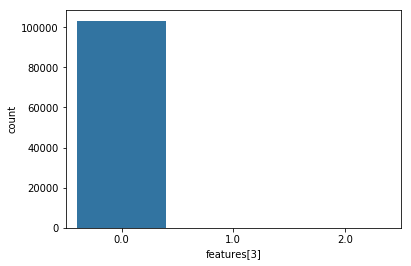

In [320]:
sns.countplot(_data_p['features[3]']);

Number of forms with feature[3] as 1 and 2 are very low, the reason why it is shown as outlier. Let's see their relationship with target variable.

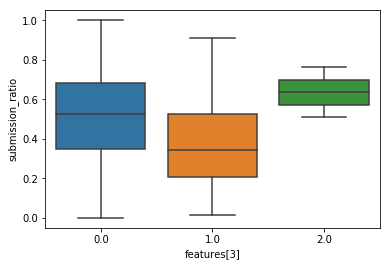

In [323]:
sns.boxplot(x='features[3]', y='submission_ratio', data=_data_p);

Clearly 'feature[3]'=2 is pushing submission ratio up!

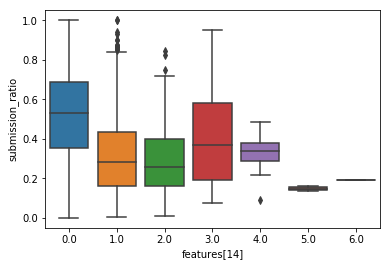

In [324]:
sns.boxplot(x='features[14]', y='submission_ratio', data=_data_p);

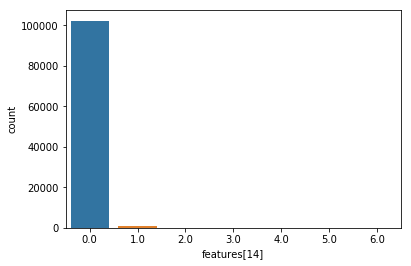

In [326]:
sns.countplot(_data_p['features[14]']);

Again!! it is the same scenario, one value out numbers all other values. Probably these variables are all categorical ordinal variables, looking at Z-score for outlier doesn't seem to be great idea.

Let's take a look at bottom of the outlier dataframe. The top is full of categorical variables, bottom I expect continuous variables.

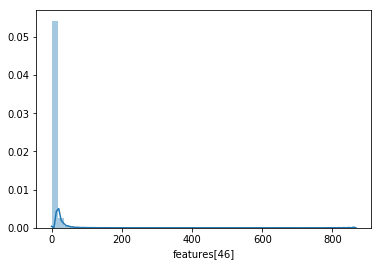

In [331]:
sns.distplot(_data_p['features[46]']);

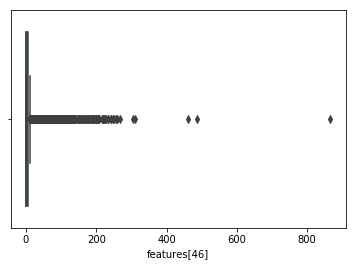

In [330]:
sns.boxplot(_data_p['features[46]']);

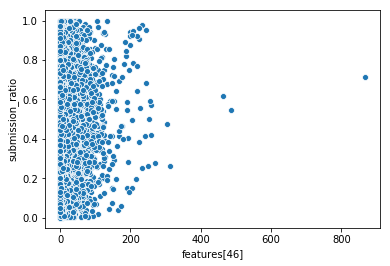

In [333]:
sns.scatterplot(x='features[46]', y='submission_ratio', data=_data_p);

Scenario did not change much either in this case as well. 'features[46]' completely skewed distribution. secondly, it does not seem to show any relation with submission ratio, though premature to conclude that way.

I don't want to treat outliers right now. If I have better knowledge about these features it is easier to understand these patterns to setup right outlier treatment. 

### Correlations

Lets look into how features are correlated. One of the methods is Pearson correlation coefficient.It can give a sense of linear relationship between variables but cannot capture non-linear relationship. 


In [179]:
correlations = _data_p.corr()['submission_ratio'].sort_values().reset_index()

In [177]:
correlations.drop(axis = 0,index=48, inplace=True)

Text(0.5, 1.0, 'correlation data by feature to target')

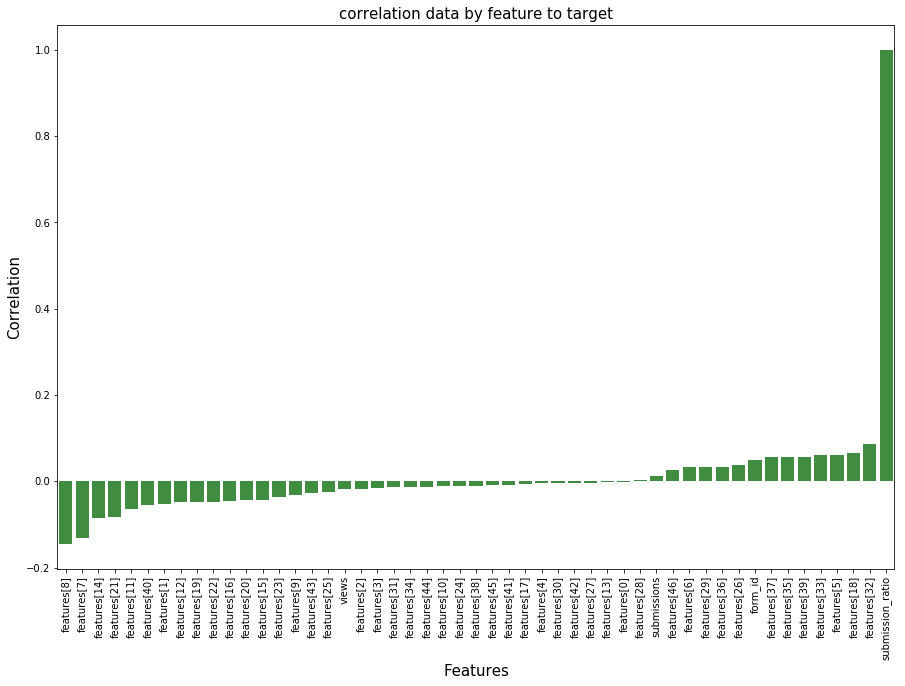

In [180]:
f,ax =plt.subplots(figsize=(15,10))
plt.xticks(rotation='90')
fig=sns.barplot(correlations['index'], correlations["submission_ratio"],color="green",alpha=0.8)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('correlation data by feature to target', fontsize=15)

Features 0, 27, 42 seems to have least correlation with target, 18,5,32,33 have relatively higher positive correlation, 8,7,14,21 have relatively high negative correlation. But, overall relationship seems to be quite weak.

In [182]:
_data_p.nunique()

form_id             103416
views                 5681
submissions           3608
features[0]              2
features[1]             26
features[2]             25
features[3]              3
features[4]             20
features[5]             39
features[6]             56
features[7]              9
features[8]             32
features[9]              9
features[10]            22
features[11]            18
features[12]            13
features[13]            28
features[14]             9
features[15]            28
features[16]            33
features[17]            25
features[18]            42
features[19]             2
features[20]            91
features[21]            45
features[22]            65
features[23]            14
features[24]            39
features[25]            13
features[26]            23
features[27]            21
features[28]            20
features[29]            47
features[30]            15
features[31]            14
features[32]            47
features[33]            39
f

## Multicollinearity

In [360]:
from pandas.plotting import scatter_matrix
corr = _data_p.corr()

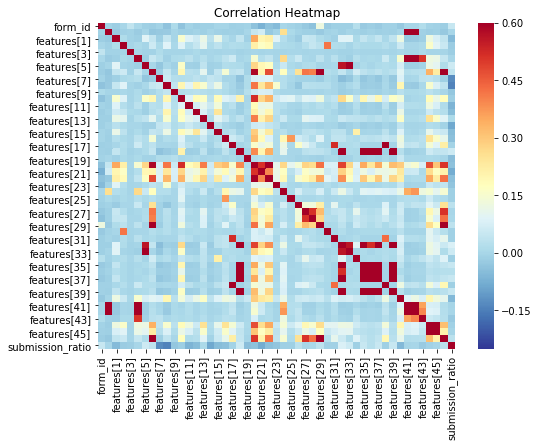

In [364]:
plt.figure(figsize = (8, 6))
sns.heatmap(corr, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = False, vmax = 0.6)
plt.title('Correlation Heatmap');

We could see there are some Dark Red and Dark blue spots. It looks like there is Multicollinearity among some variables.

Correlation plot can show only Multicollinearity resulting from linear relationship between pairs of variables, but it cannot capture Multicollinearity resulting from multi dimensional and non-linear relationship. A technique to find out such variables is using VIF.

In [376]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, Imputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [377]:
transformer = ReduceVIF()

_data_p_novif = transformer.fit_transform(_data_p.loc[:,_data_p.columns!='submission_ratio'], _data_p['submission_ratio'])

_data_p_novif.head()

ReduceVIF fit
ReduceVIF transform


/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping features[5] with vif=inf
Dropping features[20] with vif=1691.7893919774099
Dropping features[42] with vif=1277.8550605231192
Dropping features[35] with vif=485.82233666993034
Dropping features[32] with vif=167.94795504176108
Dropping features[41] with vif=7.395021827872543
Dropping features[17] with vif=6.577673785092677
Dropping features[18] with vif=6.521349699244301
Dropping features[6] with vif=6.1513575722971225


,form_id,features[0],features[1],features[2],features[3],features[4],features[7],features[8],features[9],features[10],...,features[34],features[36],features[37],features[38],features[39],features[40],features[43],features[44],features[45],features[46]
0,1135259.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
1,1145334.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,1161283.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
3,1213407.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,1213844.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0


/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


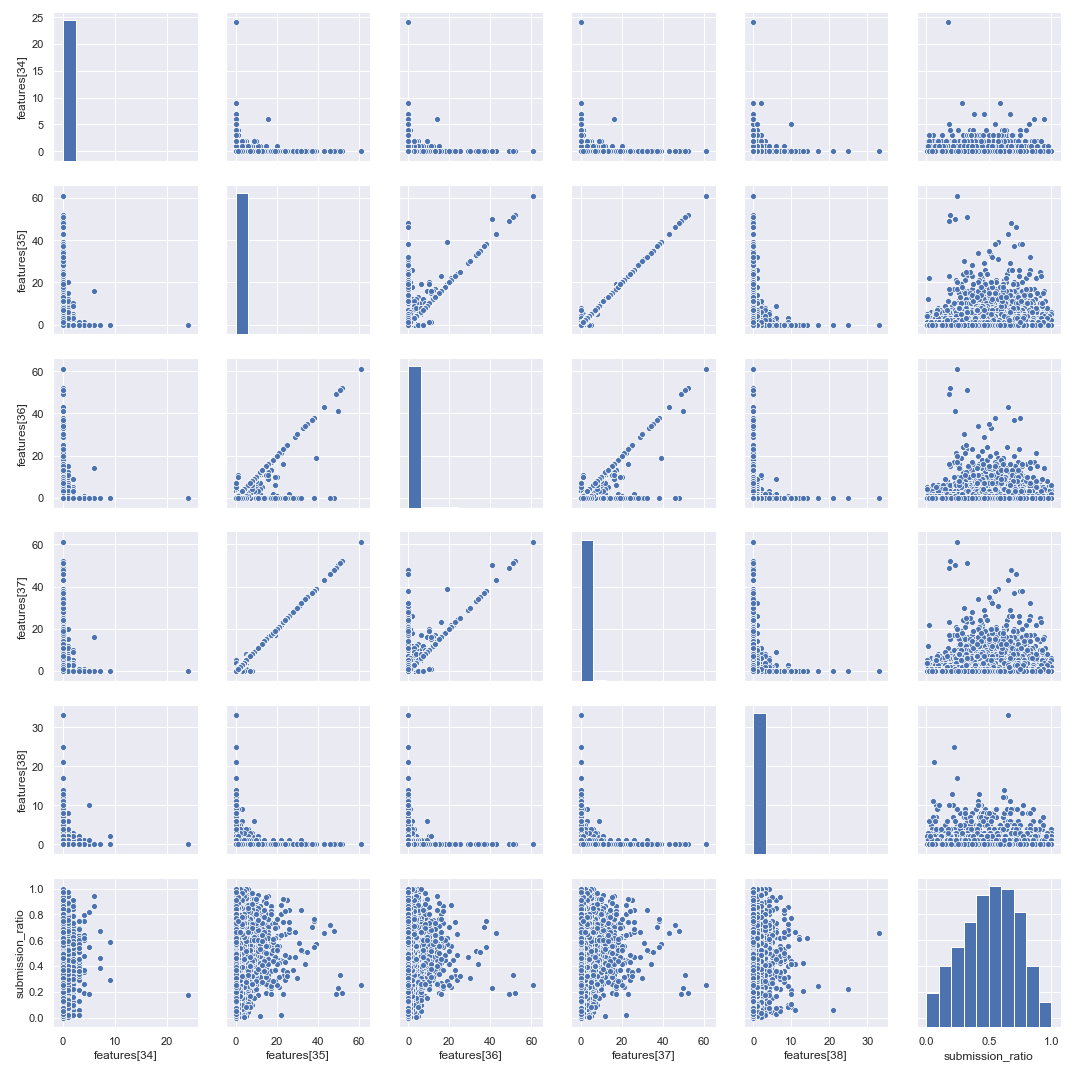

In [379]:
sns.set()
cols = ['features[34]', 'features[35]', 'features[36]', 'features[37]', 'features[38]', 'submission_ratio']
sns.pairplot(_data_p[cols], height = 2.5)
plt.show();

There are 9 features with Variable Inflation factor more than 5, created new dataframe by dropping them. During modeling we can evaluate model performance with and without these variables. For some models like KNN it does not really matter, for models like linear regression these can be big deal!

# Modeling

## Data Preparation

I'm considering only 1% sample of 1 Million rows that are provided to get the results faster with my machine. Beyond 1% my kernel crashing.

In [59]:
data_sample = data.sample(False, 0.02, seed = 20)

In [18]:
del data

In [123]:
import gc
gc.collect()

70332

In [124]:
from pyspark.ml.feature import VectorAssembler
feature_columns = data_sample.columns[3:-1]
assembler = VectorAssembler(inputCols=feature_columns,outputCol="features")

In [125]:
data_ready = assembler.transform(data_sample)

In [126]:
del data_sample

In [127]:
data_ready.select('form_id','submission_ratio','features').limit(5).toPandas()

,form_id,submission_ratio,features
0,1797676,0.078030,"(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,4492203,0.096870,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 3.0, ..."
2,11035845,0.054591,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
3,12755940,0.057725,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,3043471,0.090670,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [24]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

In [25]:
scaler_tran = scaler.fit(data_ready)

In [26]:
data_ready = scaler_tran.transform(data_ready)

In [128]:
train, test = data_ready.randomSplit([0.8, 0.2])

## Baseline Model

Let's quickly build a Linear Regression model for baseline.

In [36]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="submission_ratio")
linearModel = lr.fit(train)

In [37]:
evaluation_summary = linearModel.evaluate(test)

In [58]:
print("MAE: "+str(evaluation_summary.meanAbsoluteError))
print("RMSE: "+str(evaluation_summary.rootMeanSquaredError))
print("R2: "+str(evaluation_summary.r2))

MAE: 0.178161571554851
RMSE: 0.21671864248353478
R2: 0.06273113002844832


In [41]:
predicted = linearModel.transform(test)

In [50]:
predicted.select('prediction').show()

+-------------------+
|         prediction|
+-------------------+
| 0.4982799865735934|
| 0.5975101446717778|
|0.46883196540217176|
|  0.533628067956949|
| 0.5185797520266083|
|0.39171841686618913|
|  0.560338527974936|
| 0.5380407789752387|
| 0.5133725442373676|
| 0.5286320063854195|
| 0.5256123353936138|
| 0.5225407988507058|
| 0.5306898024640168|
| 0.5300324388994778|
| 0.4504297076048945|
| 0.5298934964238794|
|0.48813525465367197|
| 0.5528174029562607|
| 0.5219279158381149|
|0.41522620112877834|
+-------------------+
only showing top 20 rows



In [51]:
_predicted_p = predicted.toPandas()

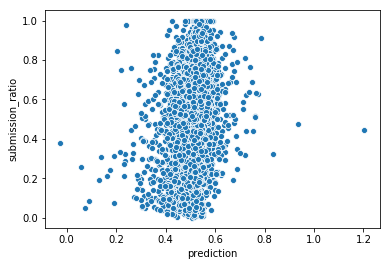

In [53]:
sns.scatterplot(x='prediction', y='submission_ratio', data=_predicted_p)

Lets keep these metrics as Baseline and explore more complex models. This model is quite poor, Need to keep in mind about the data supplied, it is just 30k samples.

## Random Forest
Let's try random forest model to see how it fares with the limited dataset.

In [20]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol="submission_ratio")

In [ ]:
rfModel = rf.fit(train)

In [62]:
predicted = rfModel.transform(test)
rf_evaluator = RegressionEvaluator(
    labelCol="submission_ratio", predictionCol="prediction", metricName="rmse")
rmse = rf_evaluator.evaluate(predicted)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.214355


This is not much improvement either. It would perform a bit better if I sample bigger dataset. Performance can be further pumped up using RandomizedSearchCV followed by GridSearchCV for hyperparameter tuning.

## Pipeline and Parameter Tuning

Here I'm building a pipeline with assembler and random forest regressor. Next built a parameter grid in to search better hyperparameters. 
3-Fold cross validation is employed to evaluate regression model.

In [21]:
pipeline = Pipeline(stages=[assembler, rf])

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 2)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 2)]) \
    .build()

evaluator = RegressionEvaluator(
    predictionCol='prediction',
    labelCol='submission_ratio',
    metricName='rmse',
)
crossval = CrossValidator(estimator=pipeline,\
                          estimatorParamMaps=paramGrid,\
                          evaluator=evaluator,\
                          numFolds=3)

In [22]:
train, test = data_sample.randomSplit([0.8, 0.2])

In [23]:
cv_model = crossval.fit(train)

In [24]:
predictions = cv_model.transform(test)

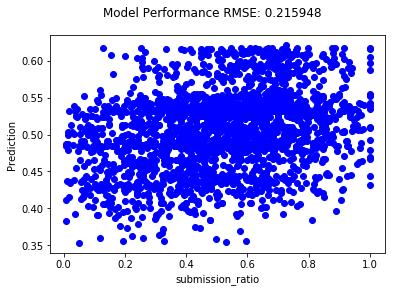

In [28]:
rmse = evaluator.evaluate(predictions)
rfPred = cv_model.transform(test)
rfResult = rfPred.toPandas()

plt.plot(rfResult.submission_ratio, rfResult.prediction, 'bo')
plt.xlabel('submission_ratio')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

Slight improvement in model performance, but looking at this plot it doesn't seem to have learned good pattern.

#### Feature Importances

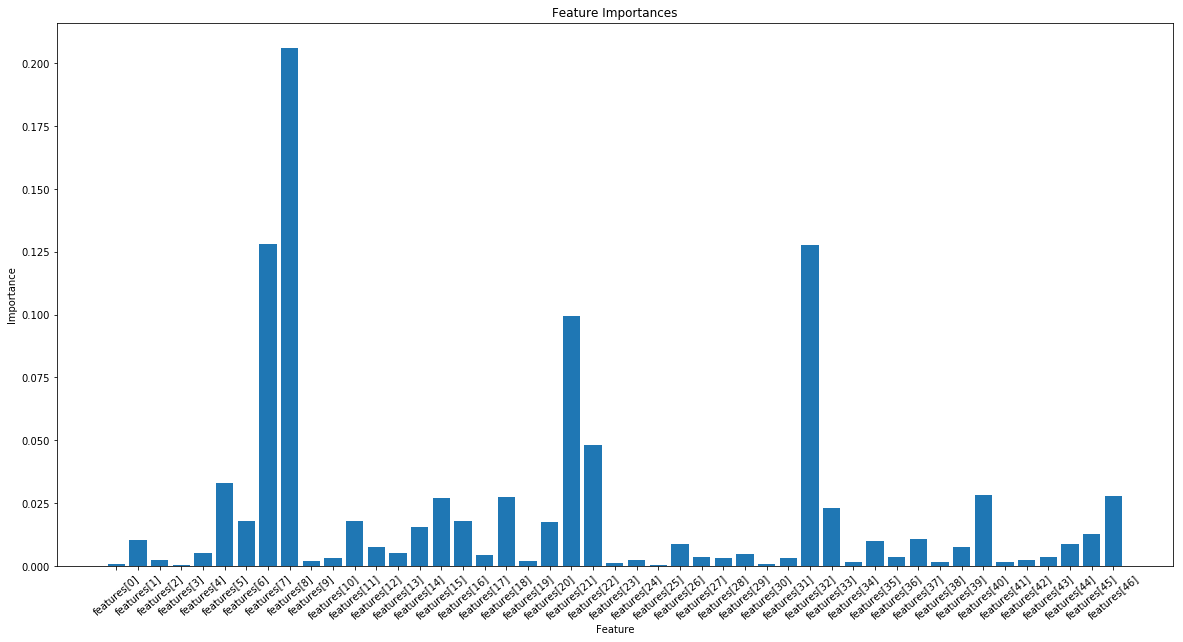

In [41]:

bestPipeline = cv_model.bestModel
bestModel = bestPipeline.stages[1]

importances = bestModel.featureImportances

x_values = list(range(len(importances)))
plt.figure(figsize = (20, 10))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_columns, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances');


Features 7,8,21,22,32 and 33 have highest importance.

# Deep Learning

Since one of the recommendation  for this assignment is using Deep Learning here I'm going to use a deep learning model, I'm sure it might just over fit because of the size of sample I'm training on (10k samples).

I'm going to pick a fully connected neural nework. CNNs or RNNs doesn't seem to be needed for this problem.

In [67]:
from pyspark.ml.feature import Bucketizer
bucketizer = Bucketizer(splits=[ 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, float('Inf') ],inputCol="submission_ratio", outputCol="submission_bucket")
df_buck = bucketizer.setHandleInvalid("keep").transform(train)


In [68]:
df_buck.count()

8440

In [129]:
nb_classes = df_buck.select("submission_ratio").distinct().count()

# Number of Inputs or Input Dimensions
input_dim = len(df_buck.select("features").first()[0])

In [130]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD

# Set up Deep Learning Model / Architecture
model = Sequential()
model.add(Dense(47, input_shape=(input_dim,)))
model.add(Activation('relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(30))
model.add(Activation('relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [131]:

# Set and Serialize Optimizer
optimizer_conf = optimizers.Adam(lr=0.01)
opt_conf = optimizers.serialize(optimizer_conf)

# Initialize SparkML Estimator and Get Settings
estimator = ElephasEstimator()
estimator.setFeaturesCol("features")
estimator.setLabelCol("submission_bucket")
estimator.set_keras_model_config(model.to_yaml())
estimator.set_categorical_labels(True)
estimator.set_nb_classes(nb_classes)
estimator.set_num_workers(1)
estimator.set_epochs(100) 
estimator.set_batch_size(128)
estimator.set_verbosity(1)
estimator.set_validation_split(0.10)
estimator.set_optimizer_config(opt_conf)
estimator.set_mode("synchronous")
estimator.set_loss("categorical_crossentropy")
estimator.set_metrics(['acc'])

ElephasEstimator_95b0f8a4b13a

In [35]:
del data_ready

In [132]:
gc.collect()


120

In [133]:
fitted_model = estimator.fit(df_buck)

/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:473: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(yaml_string)


>>> Fit model
>>> Synchronous training complete.


In [134]:
pred_train = fitted_model.transform(df_buck)
pnl_train = pred_train.select("submission_bucket", "prediction")

In [135]:
label = "submission_bucket"

In [136]:
pnl_train = pred_train.select(label, "prediction")
# pnl_test = pred_test.select(label, "prediction")

pred_and_label_train = pnl_train.rdd.map(lambda row: (row[label], row['prediction']))
# pred_and_label_test = pnl_test.rdd.map(lambda row: (row[label], row['prediction']))

metrics_train = MulticlassMetrics(pred_and_label_train)
# metrics_test = MulticlassMetrics(pred_and_label_test)

print("Training Data Accuracy: {}".format(round(metrics_train.precision(),4)))
print("Training Data Confusion Matrix")
display(pnl_train.crosstab(label, 'prediction').toPandas())

# print("\nTest Data Accuracy: {}".format(round(metrics_test.precision(),4)))
# print("Test Data Confusion Matrix")
# display(pnl_test.crosstab(label, 'prediction').toPandas())

Training Data Accuracy: 0.2828
Training Data Confusion Matrix


,submission_bucket_prediction,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
0,0.0,17,24,39,32,38,110,54,9,0,0
1,5.0,1,14,32,80,161,692,379,54,7,2
2,10.0,0,0,0,1,4,13,11,1,6,1
3,1.0,1,119,30,84,118,136,96,5,10,2
4,6.0,0,16,17,46,166,362,679,41,8,3
5,9.0,0,1,4,5,14,50,84,5,14,19
6,2.0,3,27,159,67,127,193,146,18,2,1
7,7.0,2,8,14,46,131,344,363,169,11,3
8,3.0,2,36,33,189,154,288,202,20,2,1
9,8.0,1,3,9,9,61,203,231,35,43,9
